Universidade de Brasilia
Departamento de Ciência da Computação
Projeto 1 , Fundamentos de Sistemas Inteligentes,  2022/1

Mateus de Paula Rodrigues - 190017953

In [97]:
# Universidade de Brasilia
# Departamento de Ciência da Computação
# Projeto 1 , Fundamentos de Sistemas Inteligentes,  2022/1

# Mateus de Paula Rodrigues - 190017953


import numpy as np
import pandas as pd

#sklearn usado pra montar a floresta em si

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


#usadas pra montar o plot da confusion matrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import itertools   


#************#
#*** MAIN ***#
#************#

RSEED = 6996
#'hepatitis.csv' contem ambos os dados que originalmente estavam separados para training e test
# eu vou separalos novalmente da maneira necessaria
df = pd.read_csv('hepatitis.csv').sample(155, random_state = RSEED)


Parte 1
- análise basica de dados.
- separamos a label com os resultados, e calculamos a media e desvio padrão das 19 labels com features.

In [98]:
## 1. Faça uma análise estatística inicial dos dados, plotando as quantidades médias, desvios padrões
## de todas as variáveis dos dados; (1,0 ponto)

outcome = np.array(df.pop('CLASS')) # Separa as features da label com o resultado
df = df.replace({'?': np.nan}).astype(float) #substitui '?' por na

results = []
for col in df:
    results.append([col,"%.2f" % df[col].mean(),"%.2f" % df[col].std()])
    

print(f"{'Nome:' : <15} | {'Média' : ^10} | {'DesvioPadrão' : >10}") 
print("-------------------------------------------")
for i in results:
    print(f"{i[0] : <15} | {i[1] : ^10} | {i[2] : >10}") 

Nome:           |   Média    | DesvioPadrão
-------------------------------------------
AGE             |   41.20    |      12.57
SEX             |    1.10    |       0.31
STEROID         |    1.51    |       0.50
ANTIVIRALS      |    1.85    |       0.36
FATIGUE         |    1.35    |       0.48
MALAISE         |    1.60    |       0.49
ANOREXIA        |    1.79    |       0.41
LIVER_BIG       |    1.83    |       0.38
LIVER_FIRM      |    1.58    |       0.49
SPLEEN_PALPABLE |    1.80    |       0.40
SPIDERS         |    1.66    |       0.48
ASCITES         |    1.87    |       0.34
VARICES         |    1.88    |       0.33
BILIRUBIN       |    1.43    |       1.21
ALK_PHOSPHATE   |   105.33   |      51.51
SGOT            |   85.89    |      89.65
ALBUMIN         |    3.82    |       0.65
PROTIME         |   61.85    |      22.88
HISTOLOGY       |    1.45    |       0.50


Função auxiliar evaluate_model
- Responsavel por plotar e printar a curva ROC AUC.
- Essa função e uma versão ligeiramente modificada de uma função utiliza para um trabalho de IIA.

In [99]:

def evaluate_model(model,modo):
    
    # """
    # essa funcao foi parcialmente baseada na funcao evaluate_model
    # source: https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb
    # """
    
    #######################################################
    # calcula e printa os valores                         #
    #######################################################
    if(modo):
        n_nodes = []
        max_depths = []

        for ind_tree in model.estimators_:
            n_nodes.append(ind_tree.tree_.node_count)
            max_depths.append(ind_tree.tree_.max_depth)

        print('Numero medio de nodos: ', int(np.mean(n_nodes)))
        print('Media de profundidade: ', int(np.mean(max_depths)))



    
    #codigo responsavel por plotar um grafo ROC
    
    base_fpr, base_tpr, _ = roc_curve(test_outcome, [1 for _ in range(len(test_outcome))], pos_label=2)
    model_fpr, model_tpr, _ = roc_curve(test_outcome, probs,pos_label=2)

    plt.figure(figsize = (6, 4))
    plt.rcParams['font.size'] = 16
    
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend()
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')


Função auxiliar plot_confusion_matrix
- Responsavel por plotar e printar uma Matrix de confusão.
- Essa função e uma versão ligeiramente modificada de uma função utiliza para um trabalho de IIA.

In [100]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # """
    # This function prints and plots the confusion matrix.
    # Normalization can be applied by setting `normalize=True`.
    # Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    # """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    

    plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('Outcome Verdadeira', size = 18)
    plt.xlabel('Outcome Prevista', size = 18)
    plt.show()

Parte 2 
- Separamos os dados 90% para treino 10% para teste, subistituimos NaN pela media dos valores da feature, e guardamos uma lista das features para calcular as mais importantes na parte 5.
- Montamos uma arvore de decisão solitaria, com validação cruzada.
- printamos dados da arvore e plotamos curva Roc e MC

DecisionTreeClassifier(random_state=6996)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=6996),
                   n_jobs=1,
                   param_distributions={'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['sqrt', None, 0.5, 0.6,
                                                         0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12, ...],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=6996, scoring='roc_auc')

Arvore tem: 13 nodes com profundidade maxima de: 3.
Train ROC AUC Score: 0.9156739811912226
Test ROC AUC  Score: 0.8974358974358975
Confusion matrix, without normalization


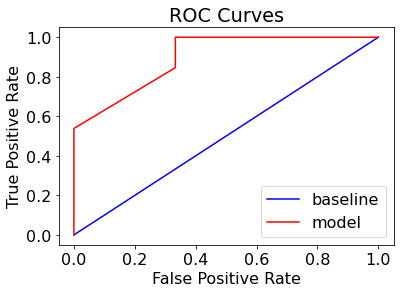

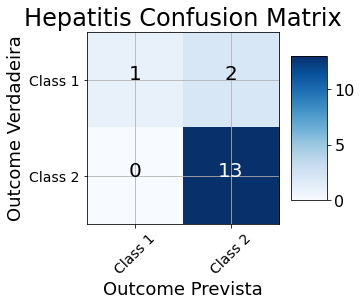

In [101]:
# 2. Construa um modelo de árvore de decisão (ID3, C4.5 ou CART), separando aleatoriamente
# sempre 10% dos dados para teste, em validação cruzada (com 10 rodadas), e mostre o resultado
# final em termos de: curva ROC, curva AUC ROC, e matriz de confusão. (2,0 pontos)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#separa os dados 
train, test, train_outcome, test_outcome  = train_test_split(df, outcome,
                                                            stratify = outcome,
                                                            test_size = 0.1,
                                                            random_state = RSEED)
#limpar nan
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Guardar Features pra parte 5
features = list(train.columns)

# monta arvore
arvore = DecisionTreeClassifier(random_state=RSEED)
arvore.fit(train, train_outcome)

# validacao cruzada
param_grid = {
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
}
rs = RandomizedSearchCV(arvore, param_grid, n_jobs = 1, 
                        scoring = 'roc_auc', cv = 10, 
                        n_iter = 10, verbose = 0, random_state=RSEED)
rs.fit(train, train_outcome)
arvore = rs.best_estimator_

# printa tamanho da arvore.
print(f'Arvore tem: {arvore.tree_.node_count} nodes com profundidade maxima de: {arvore.tree_.max_depth}.')


# coletar dados
train_probs = arvore.predict_proba(train)[:, 1]
probs = arvore.predict_proba(test)[:, 1]

train_predictions = arvore.predict(train)
predictions = arvore.predict(test)



# printa score ROC
print(f'Train ROC AUC Score: {roc_auc_score(train_outcome, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_outcome, probs)}')

# plot curva ROC
evaluate_model(arvore,False)


# plot matriz de confusão
cm = confusion_matrix(test_outcome, predictions)
plot_confusion_matrix(cm, classes = ['Class 1', 'Class 2'],
                       title = 'Hepatitis Confusion Matrix')

Parte 3 
- Treina uma floresta randomica com 100 arvores usando todas as suas features, 19. E treina com 90% dos dados separados anteriormente, usando validação cruzada para achar um modelo melhor.
- printamos dados da floresta e plotamos curva Roc e MC.

RandomForestClassifier(max_features=19, n_jobs=-1, random_state=6996)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(max_features=19, n_jobs=-1,
                                                    random_state=6996),
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12, ...],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=6996, scoring='roc_auc')

Train ROC AUC Score: 0.9959247648902821
Test ROC AUC  Score: 0.9230769230769231
Numero medio de nodos:  16
Media de profundidade:  5
Confusion matrix, without normalization


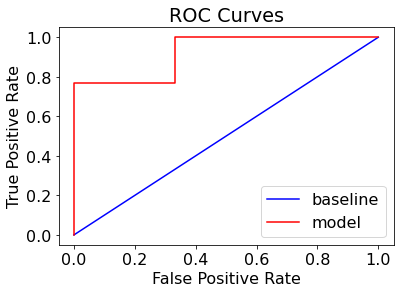

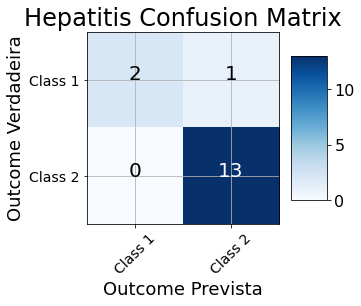

In [102]:
# 3. Construa um modelo de “floresta randômica”, com 100 árvores, usando todas as variáveis
# preditoras (i.e. m=9)19, separando aleatoriamente sempre 10% dos dados para teste, em validação
# cruzada (com 10 rodadas), e mostre o resultado final em termos de: curva ROC, curva AUC ROC, e
# matriz de confusão. (2,0 pontos)
n_arvores = 100
floresta = RandomForestClassifier(n_estimators = n_arvores, 
                               random_state=RSEED, 
                               max_features = 19,
                               n_jobs=-1, verbose = 0)

# Treinar floresta
floresta.fit(train, train_outcome)

param_grid = {
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}


# Modelo de busca aleatoria, para validação cruzada.
rs = RandomizedSearchCV(floresta, param_grid, n_jobs = 1, 
                        scoring = 'roc_auc', cv = 10, 
                        n_iter = 10, verbose = 0, random_state=RSEED)

# Trainar modelo 
rs.fit(train, train_outcome)
best_forest = rs.best_estimator_

train_probs = best_forest.predict_proba(train)[:, 1]
probs = best_forest.predict_proba(test)[:, 1]

train_predictions = best_forest.predict(train)
predictions = best_forest.predict(test)


print(f'Train ROC AUC Score: {roc_auc_score(train_outcome, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_outcome, probs)}')

# plot curva ROC
evaluate_model(best_forest,True)


# plot matriz de confusão
cm = confusion_matrix(test_outcome, predictions)
plot_confusion_matrix(cm, classes = ['Class 1', 'Class 2'],
                       title = 'Hepatitis Confusion Matrix')



Parte 4 
- Identica a parte 3, a unica modificação foi feita para usar sqrt(features).

RandomForestClassifier(max_features=4, n_jobs=-1, random_state=6996)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(max_features=4, n_jobs=-1,
                                                    random_state=6996),
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12, ...],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=6996, scoring='roc_auc')

Train ROC AUC Score: 0.9934169278996865
Test ROC AUC  Score: 0.9230769230769231
Numero medio de nodos:  20
Media de profundidade:  5
Confusion matrix, without normalization


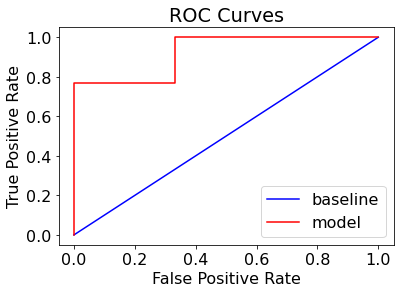

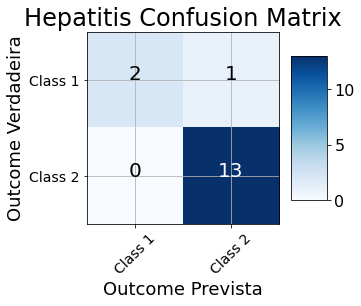

In [103]:
# 4. Construa um modelo de “floresta randômica”, com 100 árvores, usando a raiz quadrada das
# variaǘeis preditoras (i.e. m=3), separando aleatoriamente sempre 10% dos dados para teste, em
# validação cruzada (com 10 rodadas), e mostre o resultado final em termos de: curva ROC, curva
# AUC ROC, e matriz de confusão. (2,0 pontos)

n_arvores = 100
floresta2 = RandomForestClassifier(n_estimators = n_arvores, 
                               random_state=RSEED, 
                               max_features = 4,  #Unica modificacao, 4 equivalente a 'sqrt' aqui.
                               n_jobs=-1, verbose = 0)

#treinar floresta 2
floresta2.fit(train, train_outcome)

param_grid = {
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Modelo de busca aleatoria, para validação cruzada.
rs2 = RandomizedSearchCV(floresta2, param_grid, n_jobs = 1, 
                        scoring = 'roc_auc', cv = 10, 
                        n_iter = 10, verbose = 0, random_state=RSEED)

# Trainar modelo  
rs2.fit(train, train_outcome)
best_forest2 = rs2.best_estimator_

train_probs = best_forest2.predict_proba(train)[:, 1]
probs = best_forest2.predict_proba(test)[:, 1]

train_predictions = best_forest2.predict(train)
predictions = best_forest2.predict(test)


print(f'Train ROC AUC Score: {roc_auc_score(train_outcome, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_outcome, probs)}')

# plot curva ROC
evaluate_model(best_forest2,True)



# plot matriz de confusão
cm2 = confusion_matrix(test_outcome, predictions)
plot_confusion_matrix(cm2, classes = ['Class 1', 'Class 2'],
                       title = 'Hepatitis Confusion Matrix')





Parte 5 
- Construimos um dataframe com as features mais importantes da floresta 2, apesar de não ter ocorrido diferença entre os resultados das duas florestas, a quantidade de dados e limitante, mas usar cross validation melhora o desemponeo tanto das arvores como das floresta bastante.

In [104]:
# 5. Mostre, para o caso do melhor resultado, quais as 2 mais importantes/relevantes variáveis
# preditoras. (1,0 ponto)

features = list(train.columns)   
fi_model = pd.DataFrame({'feature': features,
                'importance': floresta2.feature_importances_}).\
                sort_values('importance', ascending = False)
                
print('\n',fi_model.head(8))



           feature  importance
16        ALBUMIN    0.149039
13      BILIRUBIN    0.126141
17        PROTIME    0.099650
14  ALK_PHOSPHATE    0.087790
11        ASCITES    0.081683
15           SGOT    0.077927
0             AGE    0.077101
10        SPIDERS    0.069338
